# Parameter Estimation
## Particle Smoother EM (PSEM)
### M-Step: maximize the following Monte Carlo approximation with respect to  $\theta$

$\hat{Q}_r(\theta) = \frac{1}{M_r} \sum_{j=1}^{M_r} \log p(\tilde{x}_{1:T}^j, y_{1:t};\theta)$

where

$M_r$: num. of backward trajectories

$\{ \tilde{x}_{1:T}^j \}_{j=1}^{M_r}$: $p_{\theta[r-1]}(x_{1:T}|y_{1:T})$


### E-step:
\begin{align*}
Q(\theta|\theta^{l}) &= E\left\{\log [p(N_{0,K}, x; \theta)]|| H_K, \theta^{(l)} \right\}\\
&=\int \log p(N_{0,K}, x; \theta) p(x|H_k,\theta^{(l-1)}) dx
\end{align*}

#### use Sequential Monte Carlo to sample backward smoother 

%% $E\{x_k || H_k, \theta^{(l)}\}$, $W_k = E\{x_k^2 || H_k, \theta^{(l)}\}$ and $W_{k,k+1}=E\{x_k x_{k-1} || H_k, \theta^{(l)}\}$

### M-step:

$\sigma_{\epsilon K}^{2(l+1)} = K^{-1} [\sum_{k=1}^K W_k +\sum_{k=1}^K W_{k-1} -2\sum_{k=1}^K W_{k,k-1}]$

In [36]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
%matplotlib inline
import os
import time
import numpy as np
import pandas as pd
import sys
import cPickle as pickle
from   random import *
import scipy.stats
import matplotlib.pyplot as plt
sys.path.insert(1,'./code')
from visualize import plot_raw_data, get_population_data, plot_results
from EM import TransformToProb, RunEM
import pyparticleest.models.nlg as nlg
import pyparticleest.simulator as simulator
import pyparticleest.utils.kalman as kalman
from scipy.stats import bernoulli

In [ ]:
# Get a set of whisker data and plot the raster plot
path = 'put in path to the Data folder'
resp_values_1711 = get_population_data(17,1,1, path = path)
plot_raw_data(17,1,1,0,figsize=[15,9])

resp_values_1711 is the loaded whisker data and it's of shape (50,3000), you need to sum it up across axis 0 and then use the data.

In [ ]:
print resp_values_1711.shape
Y = np.sum(resp_values_1711, axis = 0)
print Y.shape

In [ ]:
# Run EM on the data set and show results
pmode_1711, p_1711, pll_1711, pul_1711, sigma2e_1711 = RunEM(resp_values_1711)
plot_results(resp_values_1711, pmode_1711, p_1711, pll_1711, pul_1711, ylim=[0,0.75])

In [ ]:
print sigma2e_1711

Create a list of sigmas around `sigma2e_1711`.

In [ ]:
sigma_ls = np.arange(sigma2e_1711-0.2, sigma2e_1711+0.2,0.01)
print len(sigma_ls)

Now evaluate likelikehood using the list of sigmas. Feel free to play around with the list of sigmas and the step sizes.

In [38]:
class StdNonLin(nlg.NonlinearGaussianInitialGaussian):
    # x_{k+1} = x_k  + v_k = f(x_k) + v_k,
    # y_k = 0 + e_k = g(x_k) + e_k,
    # x(0) ~ N(0,P0), v_k ~ N(0,Q), e_k ~ Binom(50,\exp(x_{k})/(1+\exp(x_{k})))

    def __init__(self, P0, Q):
    # Set covariances in the constructor since they
    # are constant
        super(StdNonLin, self).__init__(Px0=P0, Q=Q)

    def calc_g(self, particles, t):
    # Calculate value of g(\xi_t,t)
         return np.zeros([len(particles),1])
    
    def calc_f(self, particles, u, t):
    # Calculate value of f(xi_t,t)
        return particles
    
    def measure(self, particles, y, t):
        """
        Return the log-pdf value of the measurement
        Args:
         - particles  (array-like): Model specific representation
           of all particles, with first dimension = N (number of particles)
         - y (array-like):  measurement
         - t (float): time-stamp
        Returns:
         (array-like) with first dimension = N, logp(y|x^i)
        """
        N = len(particles)
        trial = 50
        yrep = np.repeat(np.asarray(y), N, 0)
        coefficient = scipy.special.binom(trial, yrep)
        #lpy = scipy.stats.binom.logpmf(yrep,50,np.exp(particles[:,0])/(1.0 + np.exp(particles[:,0])),loc=0)
        lpy = np.log(coefficient) + yrep * particles[:,0] - trial * np.log(1 + np.exp(particles[:,0]))
        return lpy

In [39]:
df = pd.read_csv('thaldata.csv',header=None)
Y = df.values.reshape(3000)
#mat = np.loadtxt('train_data.txt')
#Y = mat[19,1:]
T = len(Y)

In [40]:
print Y.shape

(3000,)


In [42]:
# Forward particles
N = 1000
# Backward trajectories
M = 200
#iterations
iteration=50
#initial_sigma
sigma_ls = np.empty(iteration+1)
sigma_ls[0]=0.5

In [44]:
%%time
for i in range(iteration):
    P0 = sigma_ls[i] * np.eye(1)    
    Q = sigma_ls[i] * np.eye(1)
    model = StdNonLin(P0, Q)
    sim = simulator.Simulator(model,u=None,y=Y)
    sim.simulate(N, M, filter='PF', smoother='full', meas_first=False)
    est_smooth = sim.get_smoothed_estimates()
    posteriorcovariance=np.array(np.diff(est_smooth[:,:,0],axis=0))**2
    sigma_ls[i+1] = np.sum(posteriorcovariance/(M*T)) * np.eye(1)

KeyboardInterrupt: 

15min: 3000timesteps, 500 forward, 100 backward, 500 iterations

In [46]:
sigma_ls[:16]

array([ 0.5       ,  0.58469736,  0.63619192,  0.66253366,  0.67515802,
        0.68447703,  0.68804841,  0.68693609,  0.69001584,  0.69063597,
        0.69018036,  0.69025643,  0.69088978,  0.69148057,  0.69176352,
        0.69413138])

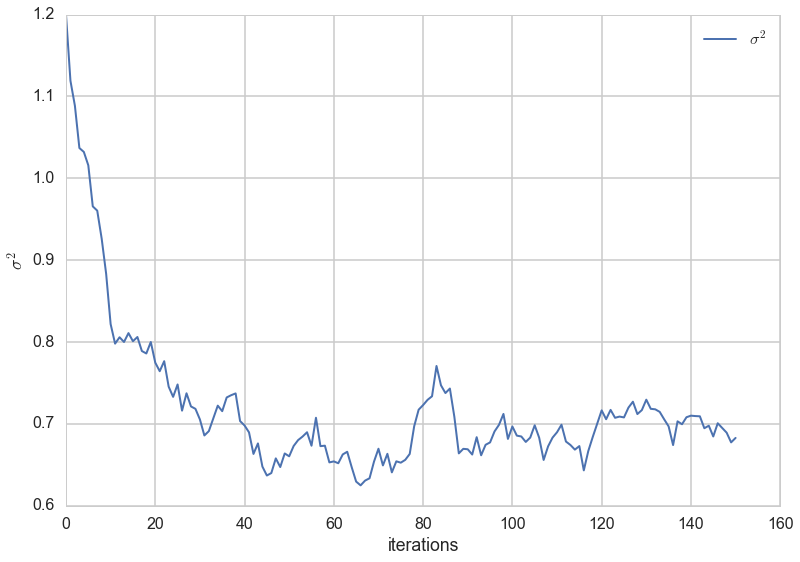

In [32]:
plt.plot(sigma_ls, '-',linewidth=2.0, label=r'$\sigma^2$')
plt.ylabel('$\sigma^2$')
plt.xlabel('iterations')
plt.legend(loc='best')

In [109]:
sigma_ls

array([ 0.01      ,  0.01250788,  0.01466892, ...,  0.10658171,
        0.10625818,  0.10945746])

In [94]:
print b.shape

(501,)


In [95]:
sigma_ls.shape

(501,)

In [100]:
e=np.reshape([b,sigma_ls],1002)

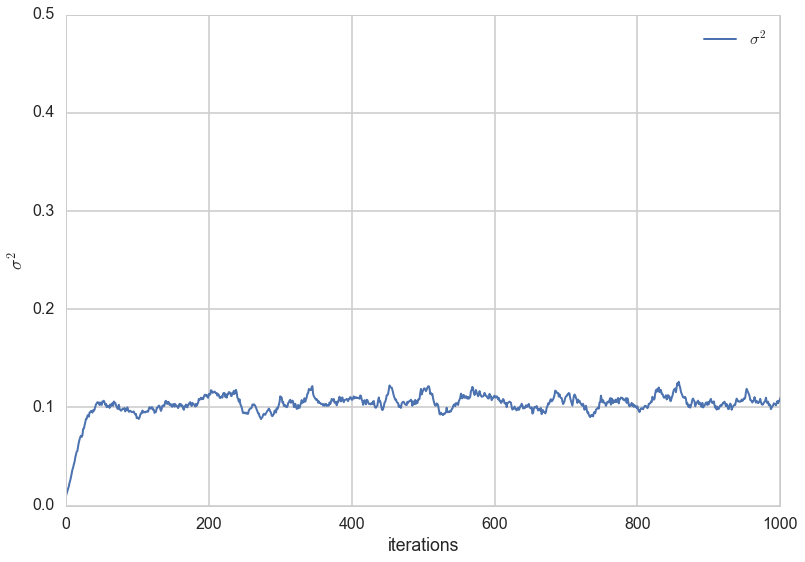

In [110]:
plt.plot(sigma_ls, '-',linewidth=2.0, label=r'$\sigma^2$')
plt.ylim([0,0.5])
plt.ylabel('$\sigma^2$')
plt.xlabel('iterations')
plt.legend(loc='best')

0